In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import math
import numpy as np
import matplotlib.pylab as pl
import matplotlib.patches as mpl_patches
import os.path
from itertools import cycle

In [2]:
n_measurements = 20 #no. of different values used
max_gRate = 0.083
immigration_rate = 0.8
K = 10000
#when deterioration greater than this value we change from immigration dominated to deterioration dominated
phase2_lim = immigration_rate/K 
phase2_lim_scaled = phase2_lim/max_gRate

N_thresh_min = 0. #range of values for N*
N_thresh_max = 1.5
delta_N_thresh = (N_thresh_max - N_thresh_min)/n_measurements

det_ratio_min = 0. #range of values for deterioration ratio
det_ratio_max = 1.5
delta_det_ratio = (det_ratio_max - det_ratio_min)/n_measurements

det_ratio_vals = np.linspace(det_ratio_min, det_ratio_max, 101)

#collection of the parameter pairs used in the histograms of the time to 1st microhab
# commented out b2 and s2 as we didn't use them for the big rep runs
histogram_param_pairs = [(1.35,  0.6),
                         #(1.20,  0.675),
                         (0.825, 1.2),
                         #(0.75,  1.35),
                         (0.6,   0.3),
                         (0.45,  1.2)]

#these are used to "easily" identify
histogram_param_pair_labels = ["b1", "b2", "s1", "s2", "r1", "r2"]

histogram_param_pair_list = [(pp[0], pp[1], l) for pp, l in zip(histogram_param_pairs, histogram_param_pair_labels)]
histogram_param_pair_list

[(1.35, 0.6, 'b1'),
 (1.2, 0.675, 'b2'),
 (0.825, 1.2, 's1'),
 (0.75, 1.35, 's2'),
 (0.6, 0.3, 'r1'),
 (0.45, 1.2, 'r2')]

In [3]:
dashed_line_vals = pd.read_csv("chris_deterministic_data/dashed_im0.8_mig0.8.dat", delimiter=" ", header=None, skiprows=1, names=["r_det_ratio", "N_theory"])
#dashed_line_vals

In [4]:
def phase_diag_line(r_det_g):
    '''
    This method calculates the theoretical blue line used for the time to first microhabitat phase diagram.
    
    Given by eqn 3 (subject to change) in the biofilm threshold theory paper
    
    r_det_g is a value of r_det/g_max
    '''
    
#     N_plus = K*(1 - r_det_g)*(0.5 + 0.5*(1. + (4.*immigration_rate)/(max_gRate*K*(1 - r_det_g)**0.5) ))
#     N_minus = K*(1 - r_det_g)*(0.5 - 0.5*(1. + (4.*immigration_rate)/(max_gRate*K*(1 - r_det_g)**0.5) ))
    
#     N_plus  = (1. - r_det_g)*(0.5+0.5*(1+(4.*immigration_rate/(max_gRate*K*(1 - r_det_g)**2)))**0.5)
#     N_minus = (1. - r_det_g)*(0.5-0.5*(1+(4.*immigration_rate/(max_gRate*K*(1 - r_det_g)**2)))**0.5)
    N_plus  = (1. - r_det_g)*(0.5 + 0.5*(1 + (4.*immigration_rate/((1 - r_det_g)**2)))**0.5)
    N_minus = (1. - r_det_g)*(0.5 - 0.5*(1 + (4.*immigration_rate/((1 - r_det_g)**2)))**0.5)
    
    return np.max([N_plus, N_minus])
    
    

In [5]:
df2 = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-1.500_rDet-0.225.csv")
new_df = pd.DataFrame(df2.mean().to_dict(),index=[df2.index.values[-1]])
new_df["time_to_n_stDev"] = df2["time_to_n"].std()
new_df["coeff_variation"] = df2["time_to_n"].std()/df2["time_to_n"].mean()
new_df
#df2
df3 = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-1.200_rDet-0.675.csv")
df3


,n_thresh,det_ratio,time_to_n,time_elapsed
0,1.2,0.675,82.862,9.000000e+09
1,1.2,0.675,114.650,9.000000e+09
2,1.2,0.675,103.875,9.000000e+09
3,1.2,0.675,109.275,9.000000e+09
4,1.2,0.675,136.975,9.000000e+09
5,1.2,0.675,80.375,9.000000e+09
6,1.2,0.675,78.875,9.000000e+09
7,1.2,0.675,166.150,9.000000e+09
8,1.2,0.675,93.025,9.000000e+09
9,1.2,0.675,137.525,9.000000e+09


In [6]:
df_list = [] #empty list to hold all the dataframes
#iterate through all the seperate csv files and append them to the list
for n in range(n_measurements+1):
    for d in range(n_measurements+1):
        n_thresh = N_thresh_min + n*(delta_N_thresh)
        det_ratio = det_ratio_min + d*(delta_det_ratio)
        
        n_thresh_str = "{:.3f}".format(n_thresh)
        det_ratio_str = "{:.3f}".format(det_ratio)
        
        df = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-"+n_thresh_str+"_rDet-"+det_ratio_str+".csv")
        df['time_to_n_raw'] = df['time_to_n']
        df['time_to_n'] = df['time_to_n']*max_gRate
        
        averaged_df = pd.DataFrame(df.mean().to_dict(),index=[df.index.values[-1]])
        averaged_df["time_to_n_stDev"] = df["time_to_n"].std()
        averaged_df["coeff_variation"] = df["time_to_n"].std()/df["time_to_n"].mean() if df["time_to_n"].mean() > 0 else None

        df_list.append(averaged_df)
        

In [7]:
#add all the dataframes together
param_data = pd.concat(df_list ,ignore_index=True)
#param_data = param_data.rename({'det_rate_ratio': 'det_rate'}, axis='columns')
#param_data['det_ratio'] = param_data['det_rate']/max_gRate
#param_data['time_adjusted'] = 0 if math.isclose(param_data['time_to_n'], 0) and param_data["time_elapsed"] > 5e5

# if param_data['time_to_n'] == 0 and param_data["time_elapsed"] > 5e5:
#     param_data['time_adjusted'] = 0.
    
# elif param_data['time_to_n'] == 0  and param_data["time_elapsed"] < 5e5:
#     param_data['time_adjusted'] = None
    
# else: param_data['time_adjusted'] = param_data['time_to_n']
#filterinfDataframe = dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
#
param_data['tN_adjusted'] = param_data["time_to_n"]
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None

param_data['tN_stDev_adjusted'] = param_data["time_to_n_stDev"]
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] > 5e5)] = 0.
param_data['tN_stDev_adjusted'][(param_data['time_to_n'] == 0.) & (param_data['time_elapsed'] < 5e5)] = None

param_data['stochasticity'] = param_data['tN_stDev_adjusted']
param_data['stochasticity'][(param_data['stochasticity'] > 0.) & param_data['stochasticity']] = param_data['tN_stDev_adjusted']/param_data['tN_adjusted']

#this line below is essential for some reason to avoid duplicate entries
param_data[param_data['time_to_n'] > 0]

print(len(param_data.index))
print(np.nanmean(param_data["tN_adjusted"]))
print(np.nanmedian(param_data["tN_adjusted"]))
#just fiddling around here to limit the range of values in the colour bar
'''UNCOMMENT THE BELOW LINE TO GET THE NICE LOOKING HEATMAP'''
#param_data["tN_adjusted"][param_data["tN_adjusted"] > 3] = 3
#param_data
#param_data["coeff_variation"][(param_data["coeff_variation"] > 0.22) | (param_data["tN_adjusted"] > 3)] = 0.22
param_data["coeff_variation"][np.isclose(param_data["n_thresh"], 0.)] = 0
#param_data["coeff_variation"][param_data["tN_adjusted"] > 3] = None

#(param_data[param_data["tN_adjusted"] > 0].sort_values(by=['coeff_variation', 'tN_adjusted'], ascending=False).head())
(param_data[param_data["tN_adjusted"] > 0].sort_values(by=["tN_stDev_adjusted"], ascending=False).head())
#(param_data[param_data["tN_adjusted"] > 0].sort_values(by=["tN_adjusted"], ascending=False).head())
(param_data[np.isclose(param_data["n_thresh"], 0.45)].sort_values(by=["tN_adjusted"], ascending=False))

441
0.9974744917161228
0.7222729166666667


,n_thresh,det_ratio,time_to_n,time_elapsed,time_to_n_raw,time_to_n_stDev,coeff_variation,tN_adjusted,tN_stDev_adjusted,stochasticity
146,0.45,1.500,0.751192,9.000000e+09,9.050500,0.022160,0.029500,0.751192,0.022160,0.029500
145,0.45,1.425,0.722273,9.000000e+09,8.702083,0.018528,0.025653,0.722273,0.018528,0.025653
144,0.45,1.350,0.693309,9.000000e+09,8.353125,0.015699,0.022644,0.693309,0.015699,0.022644
143,0.45,1.275,0.676623,9.000000e+09,8.152083,0.016531,0.024432,0.676623,0.016531,0.024432
142,0.45,1.200,0.656565,9.000000e+09,7.910417,0.012643,0.019256,0.656565,0.012643,0.019256
141,0.45,1.125,0.635815,9.000000e+09,7.660417,0.012921,0.020322,0.635815,0.012921,0.020322
140,0.45,1.050,0.622759,9.000000e+09,7.503125,0.015054,0.024173,0.622759,0.015054,0.024173
139,0.45,0.975,0.608580,9.000000e+09,7.332292,0.007481,0.012293,0.608580,0.007481,0.012293
138,0.45,0.900,0.593191,9.000000e+09,7.146875,0.009103,0.015345,0.593191,0.009103,0.015345
137,0.45,0.825,0.577196,9.000000e+09,6.954167,0.015219,0.026368,0.577196,0.015219,0.026368


In [8]:
pivot = param_data.pivot(index='n_thresh', columns='det_ratio', values='tN_adjusted')

In [9]:
theoryvals = np.vectorize(phase_diag_line)(det_ratio_vals)

1.52469507659596
0.6787087810503355
1.45608311
1.00191157


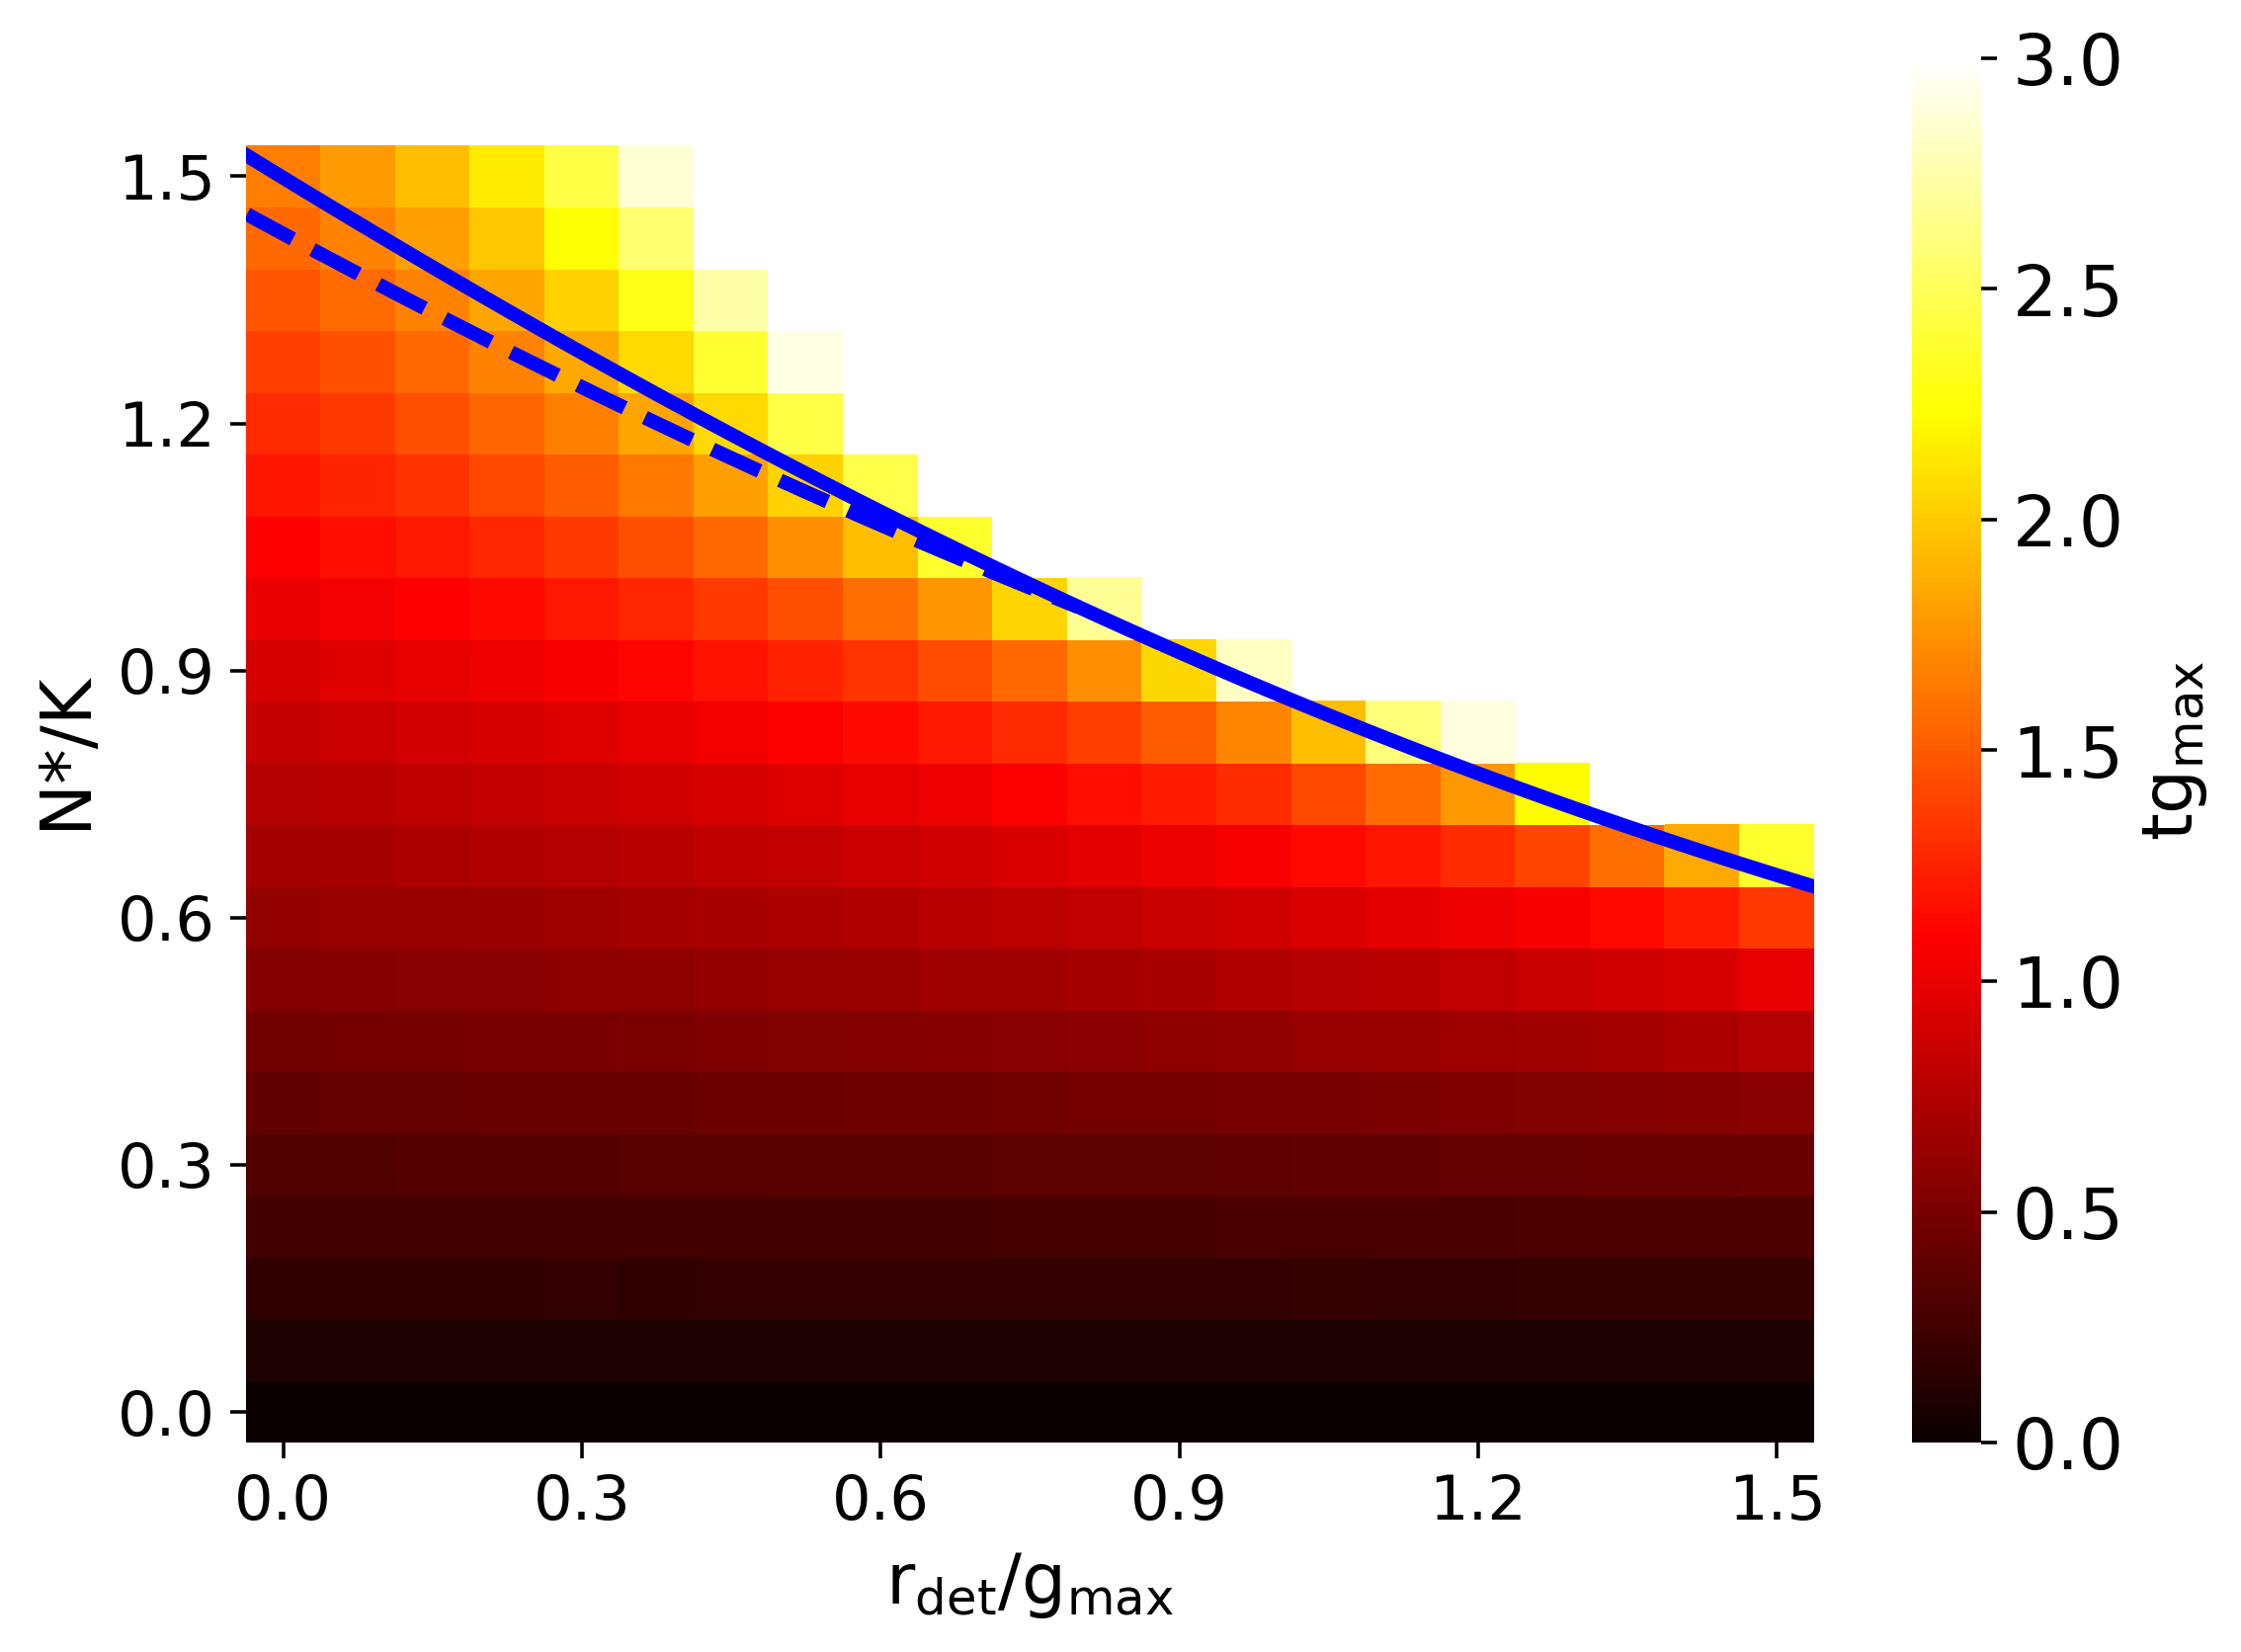

In [10]:
fig, ax = plt.subplots(dpi=320)
fig.set_size_inches(8, 5.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True, vmax=3)
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.1f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.1f}".format(float(y)), labels_y))


#plot the theoretical blue line #####################
theoryN_vals = np.vectorize(phase_diag_line)(det_ratio_vals)
# theoryN_vals[0] = 1.5
# theoryN_vals[-1] = 0.6
print(theoryN_vals[0])
print(theoryN_vals[-1])

#in order to get the line to be positioned correctly, need to multiply it by this scale factor.
#equal to the max value of the line divided by no. of squares in each axis
nsquares = len(param_data.index)**0.5 #no. of squares in each axis
scale_factor_x = nsquares/1.5
scale_factor_y = nsquares/1.5
sns.lineplot(x=det_ratio_vals*scale_factor_x, y=theoryN_vals*scale_factor_y, linewidth = 3.2, color="blue")
line = ax.lines[0] # get the line
line.set_ydata(line.get_ydata() - 0.5)



#plot the dashed line
det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]
print(theoryN_vals_dashed[0])
print(np.min(theoryN_vals_dashed))

scale_factor_x_dashed = nsquares/1.5
scale_factor_y_dashed = nsquares/1.5

sns.lineplot(x=det_ratio_vals_dashed*scale_factor_x_dashed, y=theoryN_vals_dashed*scale_factor_y_dashed, linewidth = 3.2, color="blue")
line = ax.lines[1] # get the line
line.set_ydata(line.get_ydata() - 0.5)
line.set_linestyle("--")
###########################################

ax.axis('tight')

ax.set_xlabel('r$_{\\rm det}/\\rm{g}_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
ax.yaxis.set_tick_params(labelsize=numbersize)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("tg$_{\max}$", fontsize=labelSize)
cbar.ax.locator_params(nbins=6)

plt.xticks(rotation=0)
plt.savefig('paper_plots/timeTo1Mh_heatmap.pdf', bbox_inches='tight')
plt.show()

In [11]:
pivot_stDev = param_data.pivot(index='n_thresh', columns='det_ratio', values='coeff_variation')

1.52469507659596
0.6787087810503355
1.45608311
1.00191157


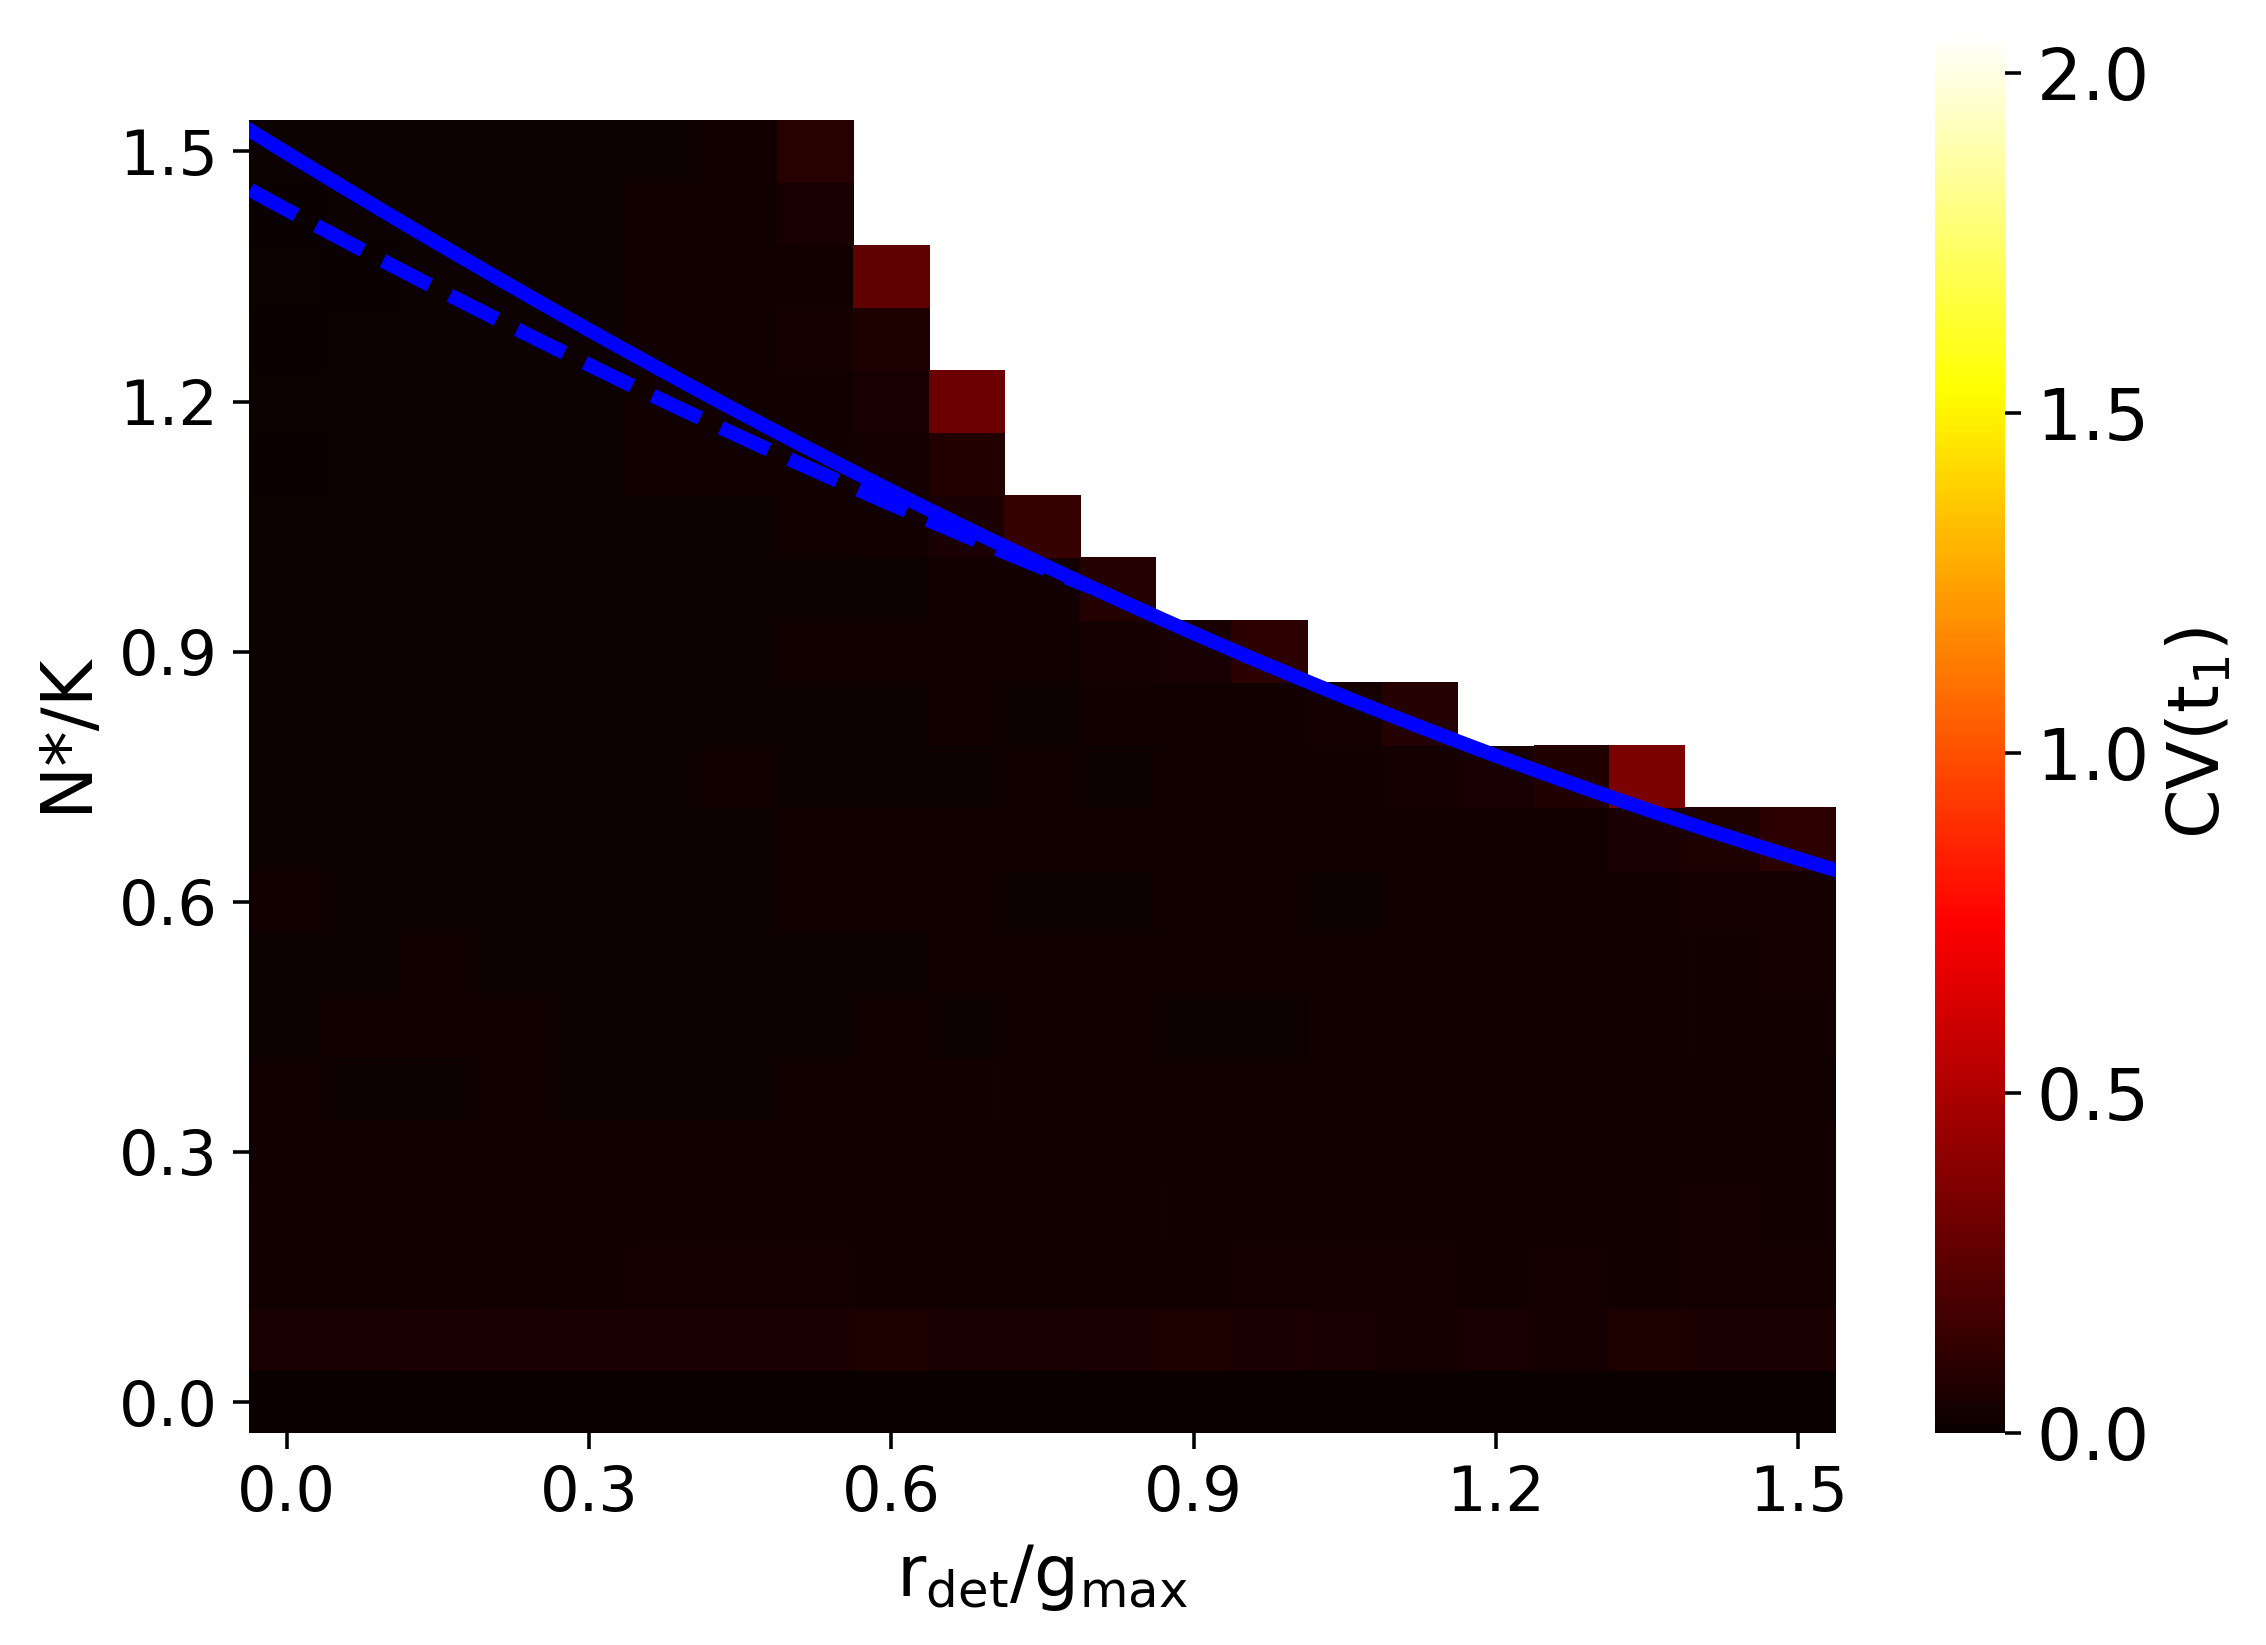

In [12]:
fig, ax = plt.subplots(dpi=320)
fig.set_size_inches(8, 5.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((-3, -2))

# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot_stDev, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True, cbar_kws={'format':formatter})
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.1f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.1f}".format(float(y)), labels_y))

#plot the theoretical blue line #####################
theoryN_vals = np.vectorize(phase_diag_line)(det_ratio_vals)
# theoryN_vals[0] = 1.5
# theoryN_vals[-1] = 0.6
print(theoryN_vals[0])
print(theoryN_vals[-1])

#in order to get the line to be positioned correctly, need to multiply it by this scale factor.
#equal to the max value of the line divided by no. of squares in each axis
nsquares = len(param_data.index)**0.5 #no. of squares in each axis
scale_factor_x = nsquares/1.5
scale_factor_y = nsquares/1.5
sns.lineplot(x=det_ratio_vals*scale_factor_x, y=theoryN_vals*scale_factor_y, linewidth = 3.2, color="blue")
line = ax.lines[0] # get the line
line.set_ydata(line.get_ydata() - 0.5)



#plot the dashed line
det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]
print(theoryN_vals_dashed[0])
print(np.min(theoryN_vals_dashed))

scale_factor_x_dashed = nsquares/1.5
scale_factor_y_dashed = nsquares/1.5

sns.lineplot(x=det_ratio_vals_dashed*scale_factor_x_dashed, y=theoryN_vals_dashed*scale_factor_y_dashed, linewidth = 3.2, color="blue")
line = ax.lines[1] # get the line
line.set_ydata(line.get_ydata() - 0.5)
line.set_linestyle("--")
###########################################



ax.axis('tight')

ax.set_xlabel('r$_{\\rm det}/\\rm{g}_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
ax.yaxis.set_tick_params(labelsize=numbersize)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("CV(t$_1$)", fontsize=labelSize)

#cbar = plt.colorbar()
cbar.ax.locator_params(nbins=6)

plt.xticks(rotation=0)
plt.savefig('paper_plots/CV_t1_heatmap.pdf', bbox_inches='tight')
plt.show()

In [13]:
def get_t1_vs_r_det(param_df, N_thresh):
    '''
    To see how t1 varies with the parameters, we'll plot a series of line graphs.  Each line will be a different value of N*,
    x axis will be r_det and y-axis will be t1.  (Essentially going from left to right on the heatmaps)
    
    DON'T FORGET TO REMOVE THE AESTHETIC ALTERATIONS MADE TO THE DATAFRAME AT THE START OF THE NOTEBOOK.
    '''
    
    r_det_vals = param_df["det_ratio"][np.isclose(param_df["n_thresh"], N_thresh)]
    t1_vals = param_df["tN_adjusted"][np.isclose(param_df["n_thresh"], N_thresh)]
    #print(r_det_vals)
    return r_det_vals, t1_vals

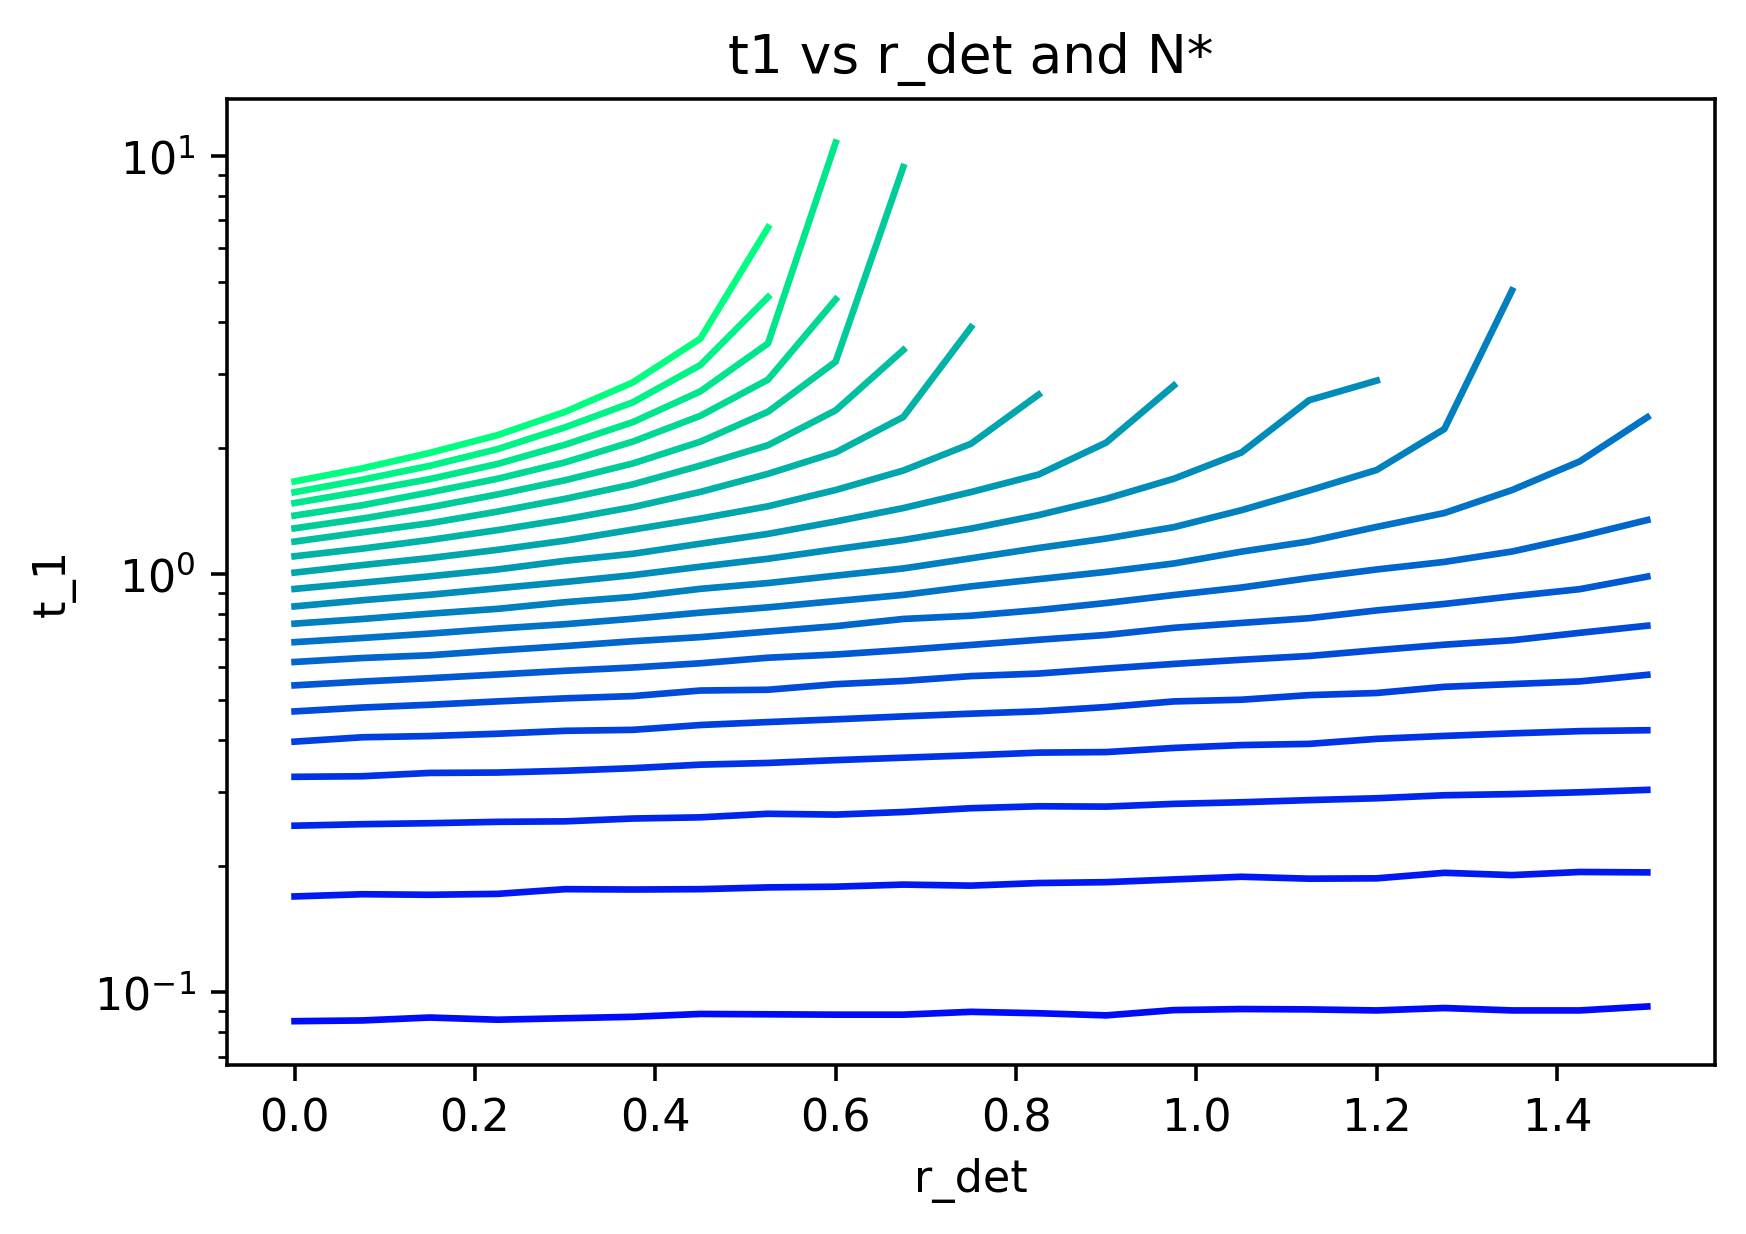

In [14]:
fig, ax = plt.subplots(dpi=320)

n_thresh_vals = np.arange(N_thresh_min, N_thresh_max+delta_N_thresh, delta_N_thresh)
nCols = n_thresh_vals.size #no. of runs. -1 due to the time column
colors = pl.cm.winter(np.linspace(0,1,nCols))
i = 0

for n_thresh in n_thresh_vals:
    #print(n_thresh)
    r_det_data, t1_data = get_t1_vs_r_det(param_data, n_thresh)
    
    ax.plot(r_det_data, t1_data, color=colors[i], label=n_thresh)
    i += 1

#plt.semilogy()
#plt.legend(ncol=3)
plt.xlabel("r_det")
plt.ylabel("t_1")
plt.title("t1 vs r_det and N*")

plt.savefig("paper_plots/heatmap_powerlaw.png")
plt.semilogy()
plt.savefig("paper_plots/heatmap_powerlaw_logy.png")
plt.show()

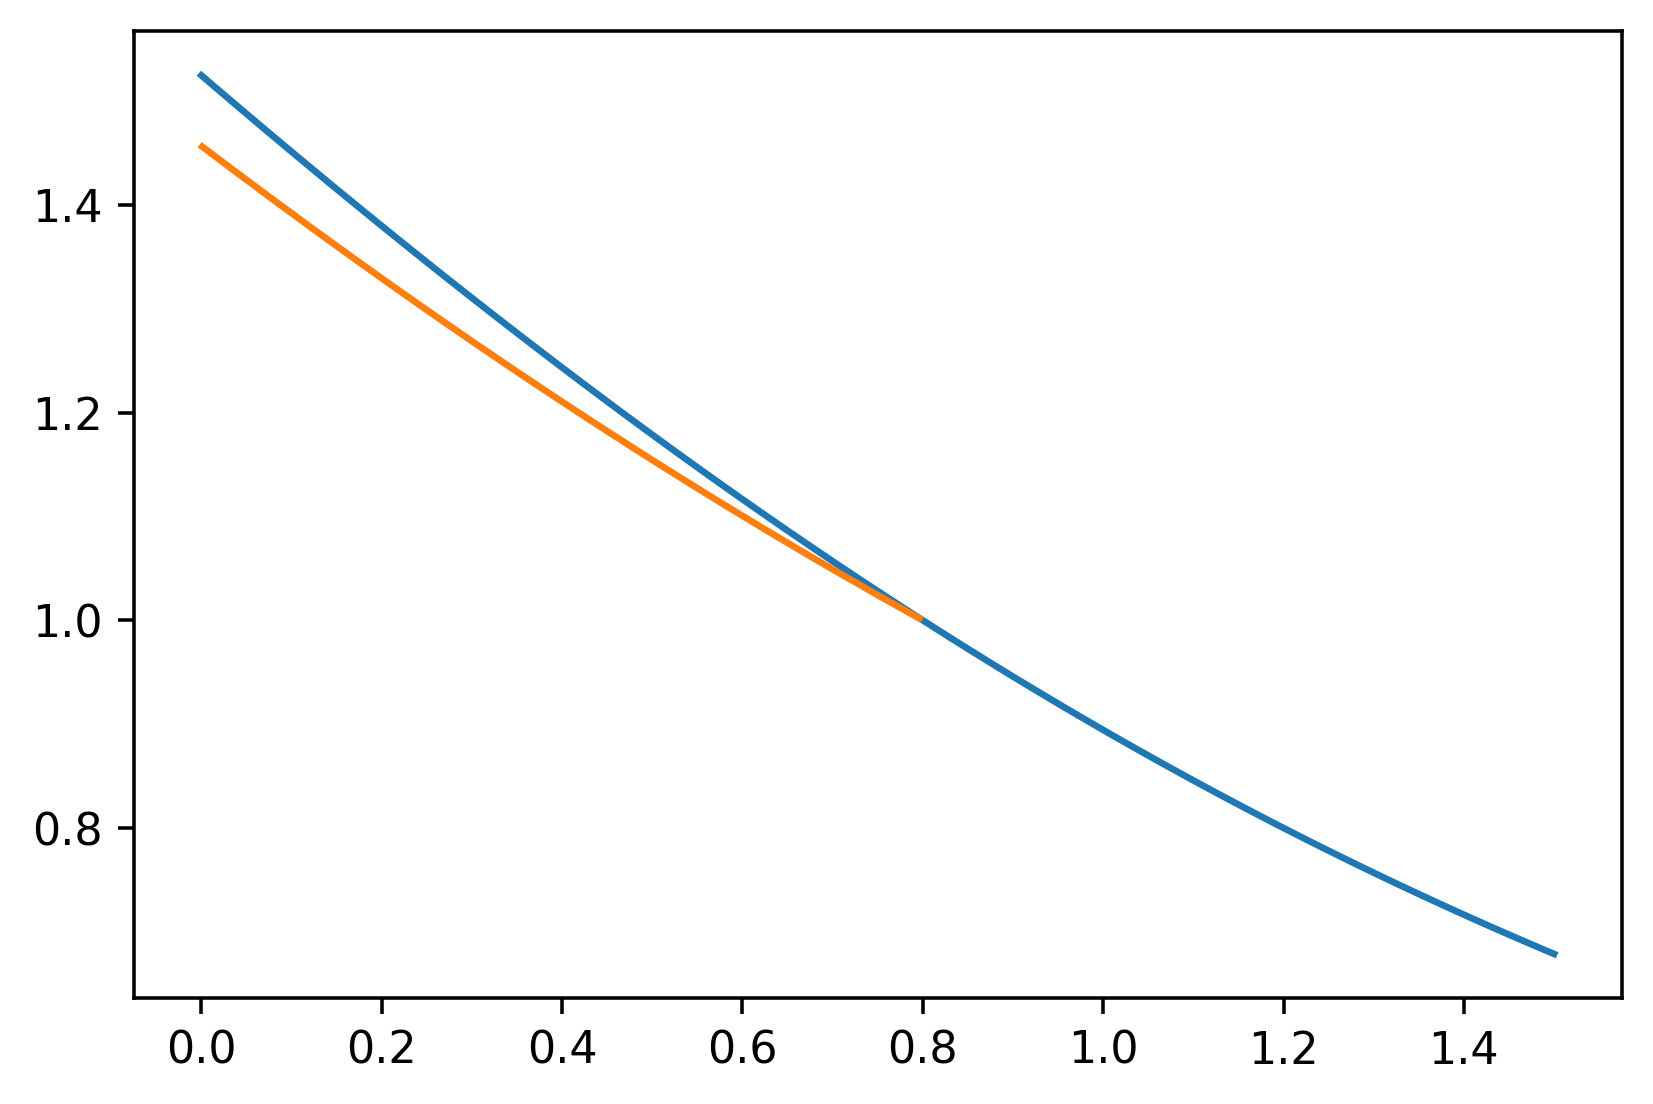

In [15]:
fig, ax = plt.subplots(dpi=320)
ax.plot(det_ratio_vals, np.vectorize(phase_diag_line)(det_ratio_vals))

det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]

ax.plot(det_ratio_vals_dashed, theoryN_vals_dashed)

In [16]:
def getT1HistoDataAndProcess(n_thresh, r_det, extra_N_vs_t_runs=False, reps500=False):
    '''
    This gets the datasets for the 100 runs of the time to 1st microhabitat sims (used to histogram the distribution of t1)
    Also uses the 24 runs used to make the phase diagram, so there's more data to use
    Also adds in a column with the scaled time, to compare with the phase diagram
    '''
    df_list = []
    df1 = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/t1_histogram-N_thresh="+"{:.3f}".format(n_thresh)+"-r_det_ratio="+"{:.3f}".format(r_det)+".csv")
    df2 = pd.read_csv("timeTo1Microhab_phaseDiagram_bigK/mhLim-1_N^-"+"{:.3f}".format(n_thresh)+"_rDet-"+"{:.3f}".format(r_det)+".csv")
    
    df_list.append(df1)
    df_list.append(df2)
    
    #reps 500 is for b1, s1, r1 and r2, the big 500 rep runs
    if reps500:
        df_500reps = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/t1_histogram-N_thresh="+"{:.3f}".format(n_thresh)+"-r_det_ratio="+"{:.3f}".format(r_det)+"-manyReps.csv")
    
    if extra_N_vs_t_runs:
        df_extra = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh="+"{:.3f}".format(n_thresh)+"_rDet="+"{:.3f}".format(r_det)+"-stochastic_microhabs_over_time.csv")
        df_extra["time_to_n"] = df_extra[" t_mh_0"]
        df_list.append(df_extra)
        
    #run 2 (better sampling used for the N over t files)
    #finesample_file = Path("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh="+"{:.3f}".format(n_thresh)+"_rDet="+"{:.3f}".format(r_det)+"-stochastic_microhabs_over_time_run2.csv")
    if os.path.isfile("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh="+"{:.3f}".format(n_thresh)+"_rDet="+"{:.3f}".format(r_det)+"-stochastic_microhabs_over_time_run2.csv"):
        df_extra_fine = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh="+"{:.3f}".format(n_thresh)+"_rDet="+"{:.3f}".format(r_det)+"-stochastic_microhabs_over_time_run2.csv")
        df_extra_fine["time_to_n"] = df_extra_fine["t_mh_0"]
        df_list.append(df_extra_fine)

    df = pd.concat(df_list, ignore_index=True)
    df["t_scaled"] = df['time_to_n']*max_gRate
    
    return df
    

def plotT1Histogram(n_thresh, r_det, nbins, extra_N_vs_t_runs=False):
    
    fig, ax = plt.subplots(dpi=180)
    data = getT1HistoDataAndProcess(n_thresh, r_det, extra_N_vs_t_runs)
    
    t1_mean = data["t_scaled"].mean()
    t1_std  = data["t_scaled"].std()
    
    #use the legend as a hacky way to annotate the mean and stdev
    # create a list with two empty handles (or more if needed)
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 2
    labels=[]
    labels.append("mean(t$_1$) = {:.3f}".format(t1_mean))
    labels.append("std(t$_1$) = {:.3f}".format(t1_std))
    
    plt.hist(data["t_scaled"], bins=nbins)
    plt.title("N* = {:.3f},$\quad \quad$ r_det = {:.3f}".format(n_thresh, r_det), fontsize=14)
    plt.xlabel("t$_1$ * g$_\max$", fontsize=16)
    #plt.text(0.5, 0.9, "mean(t$_1$) = {:.3f}".format(t1_mean), transform=ax.transAxes, fontsize=16)
    #plt.text(0.5, 0.8, "std(t$_1$) = {:.3f}".format(t1_std), transform=ax.transAxes, fontsize=16)
    ax.legend(handles, labels, loc="best", handlelength=0, handletextpad=0, fontsize=14)
    plt.savefig('timeTo1Microhab_powerLaw_bigK_plots/n_thresh={:.3f}-r_det={:.3f}.pdf'.format(n_thresh, r_det), bbox_inches='tight')
    plt.show()
    
    

In [17]:
df55 = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh=0.600_rDet=0.300-stochastic_pop_over_time_run2.csv")
#df55 = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh=0.825_rDet=1.200-stochastic_microhabs_over_time.csv")
#df55["time_to_n"] = df55["t_mh_0"]
df55.keys()

df66 = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh=0.825_rDet=1.200-stochastic_pop_over_time.csv")
#df55[" t_mh_1"].max()
df55.keys()

Index(['t', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=101)

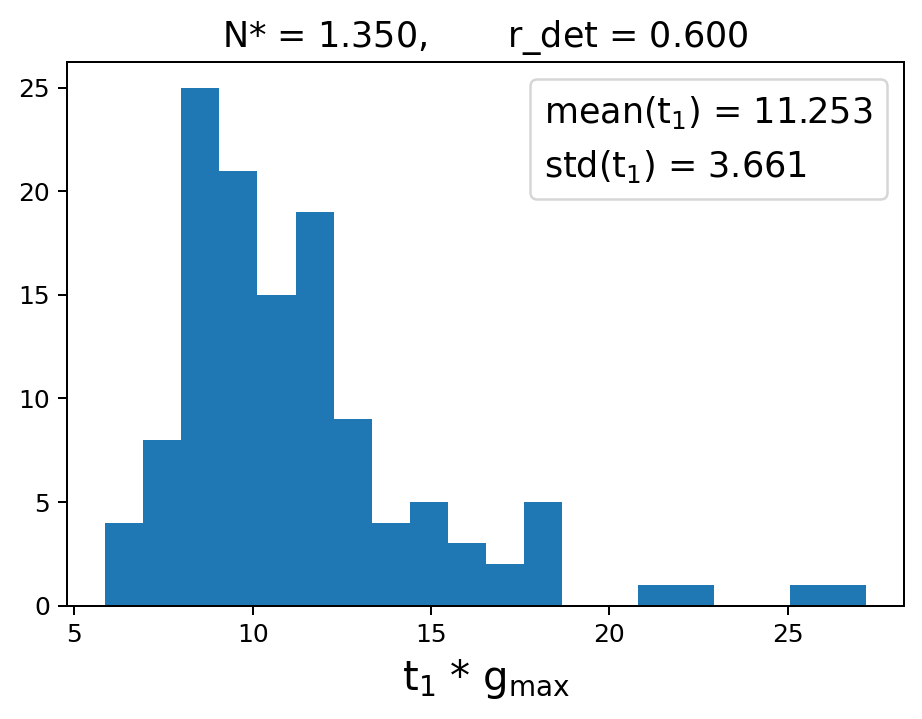

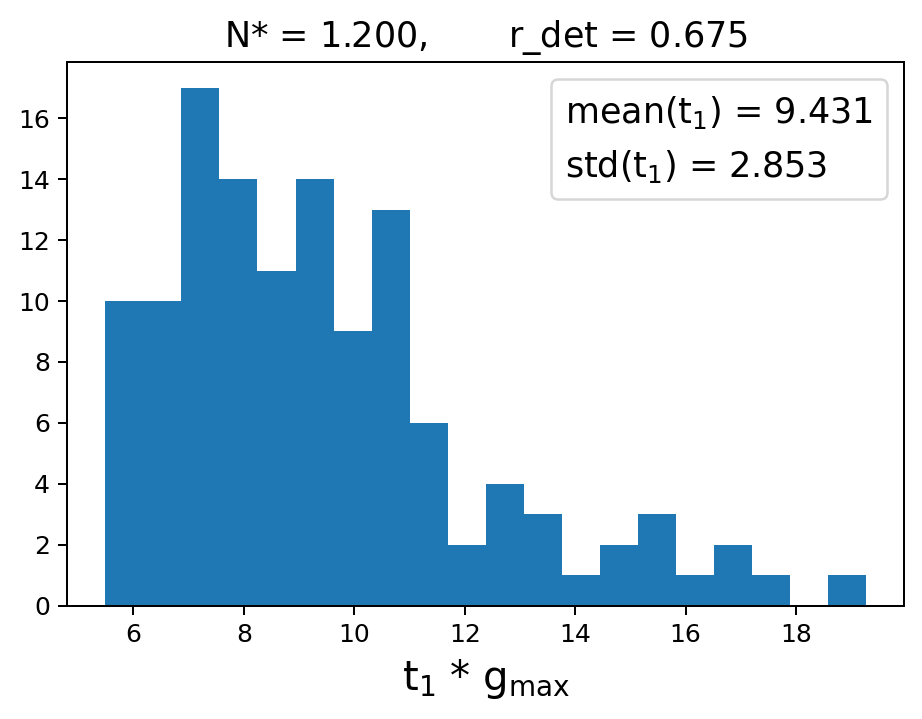

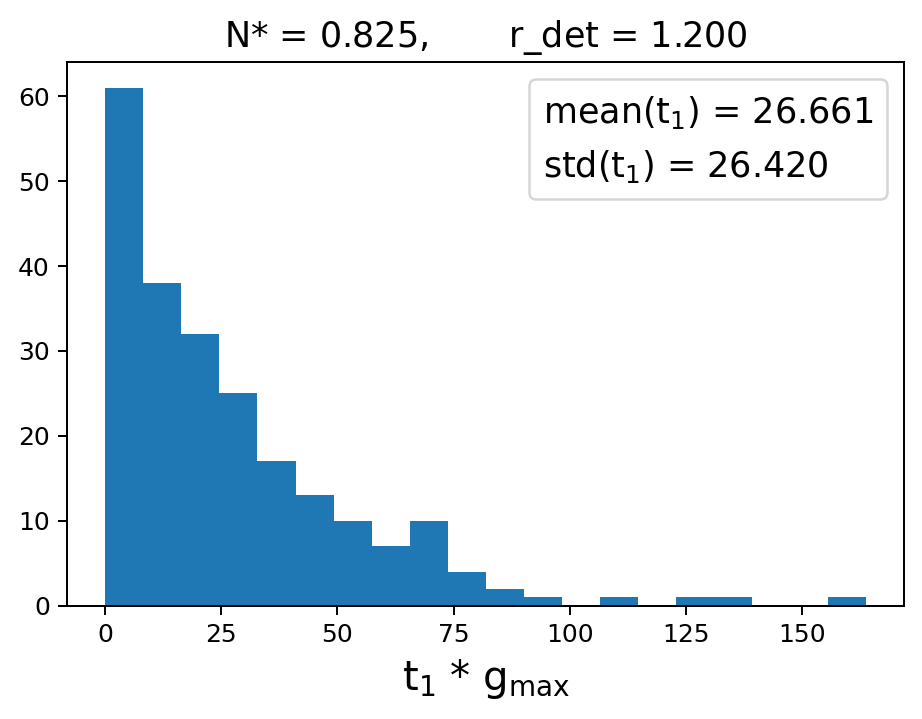

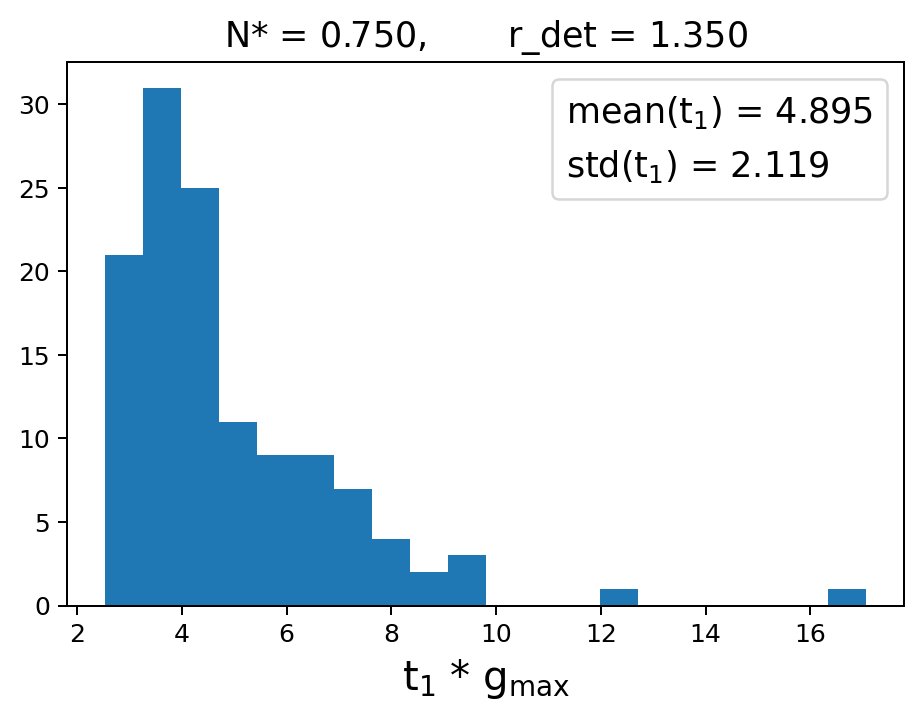

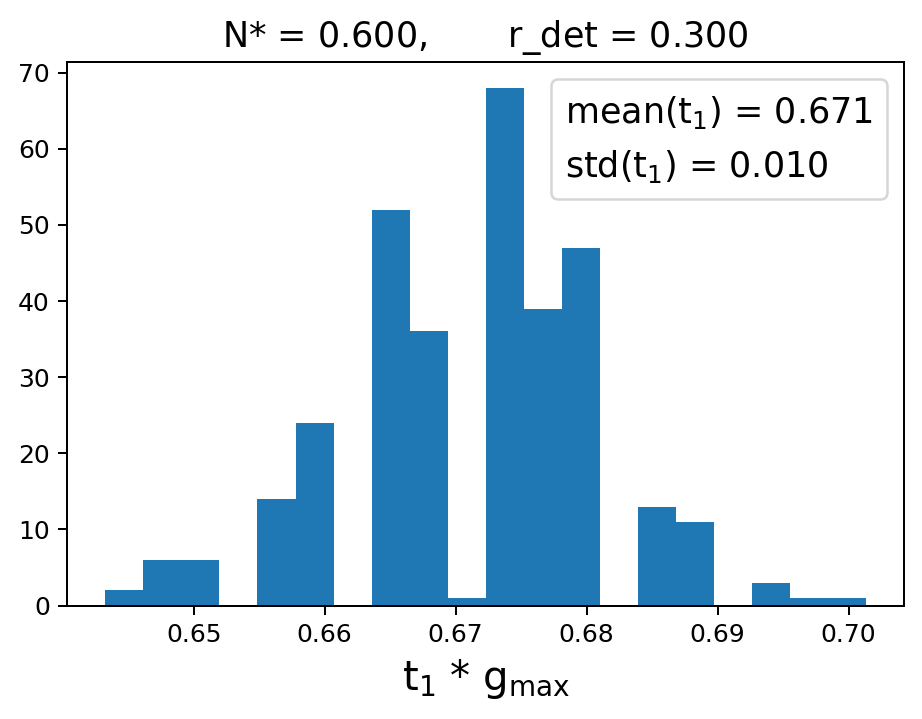

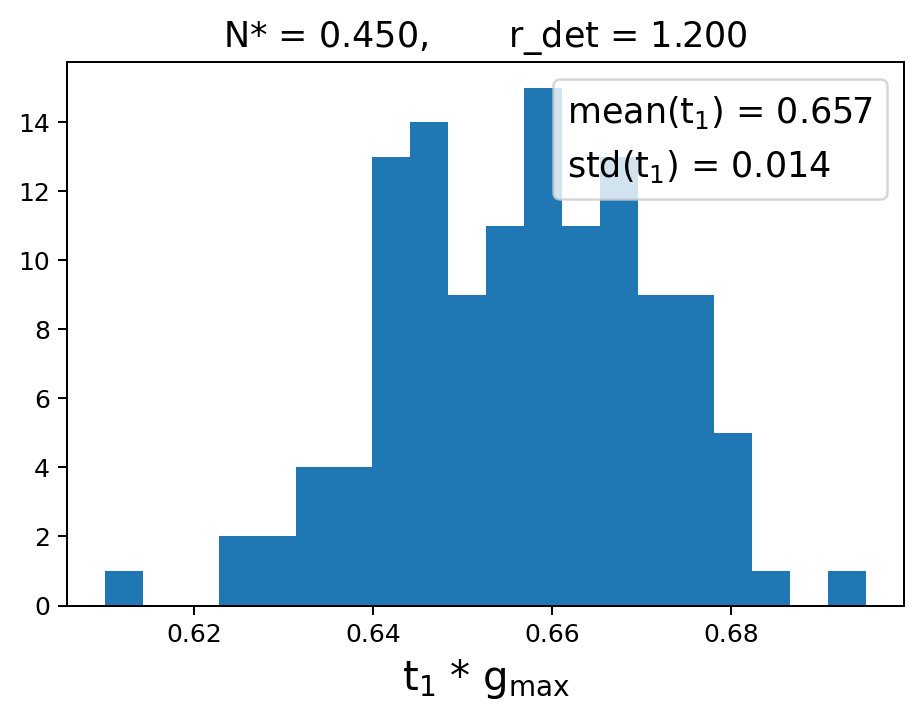

In [18]:
for n_thresh, r_det in histogram_param_pairs:
    #also include the extra runs if there are any
#     if (math.isclose(n_thresh, 0.825) and math.isclose(r_det, 1.2)) or (math.isclose(n_thresh, 0.6) and math.isclose(r_det, 0.3)):
#         extra_N_vs_t_runs = True
#     else:
#         extra_N_vs_t_runs = False
        
    extra_N_vs_t_runs = (math.isclose(n_thresh, 0.825) and math.isclose(r_det, 1.2)) or (math.isclose(n_thresh, 0.6) and math.isclose(r_det, 0.3))
        
    plotT1Histogram(n_thresh, r_det, nbins=20, extra_N_vs_t_runs=extra_N_vs_t_runs)

In [19]:
def plotT1PowerLawNOverTime(n_thresh, r_det):
    '''Used to plot the populations over time for some of the parameter pairs used in the phase diagram'''
    pop_dataset = pd.read_csv("timeTo1Microhab_powerLaw_bigK_results/N_vs_t/nThresh="+"{:.3f}".format(n_thresh)+"_rDet="+"{:.3f}".format(r_det)+"-stochastic_pop_over_time_run2.csv")
    nRuns = len(pop_dataset.columns) - 1 #no. of runs performed, -1 to account for the time column
    fig, ax = plt.subplots(figsize=(6,5), dpi=120)
    plt.rcParams['font.sans-serif'] = "Arial"
    K_val = 10000
    colors = pl.cm.twilight_shifted_r(np.linspace(0,1,nRuns))
    #allows us to alternate line styles for the different runs
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines[::-1])
    #print(pop_dataset.keys())
    
    for p in range(nRuns):

            #ax.plot(pop_dataset['t']*max_gRate, pop_dataset[str(p)]/K_val, lw=2.2, color=colors[p], ls=next(linecycler))
        ax.plot(pop_dataset['t'][:-1]*max_gRate, pd.to_numeric(pop_dataset[str(p)][:-1])/K_val, lw=2.2, color=colors[p], ls=next(linecycler))
    
    ax.set_ylabel("N/K", fontsize=16)
    ax.set_xlabel("tg$_{\\rm max}$", fontsize=16)
    plt.title("N* = {:.3f},$\quad \quad$ r_det = {:.3f}".format(n_thresh, r_det), fontsize=14)
    plt.show()

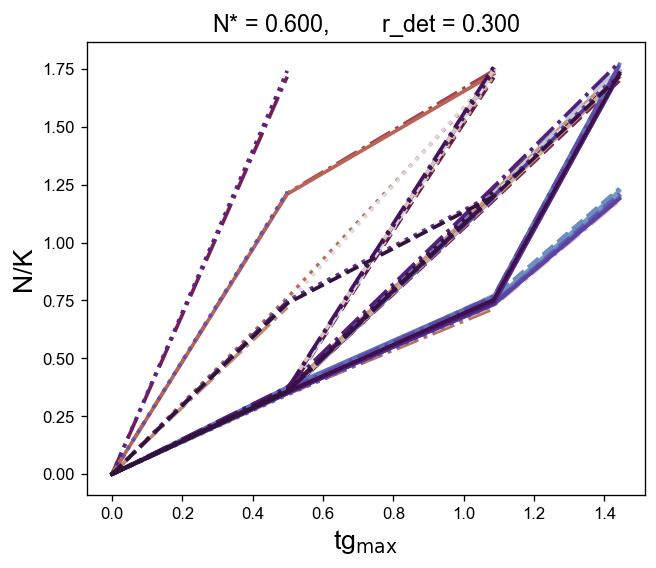

In [20]:
plotT1PowerLawNOverTime(0.6, 0.3)

In [21]:
pivot = param_data.pivot(index='n_thresh', columns='det_ratio', values='tN_adjusted')

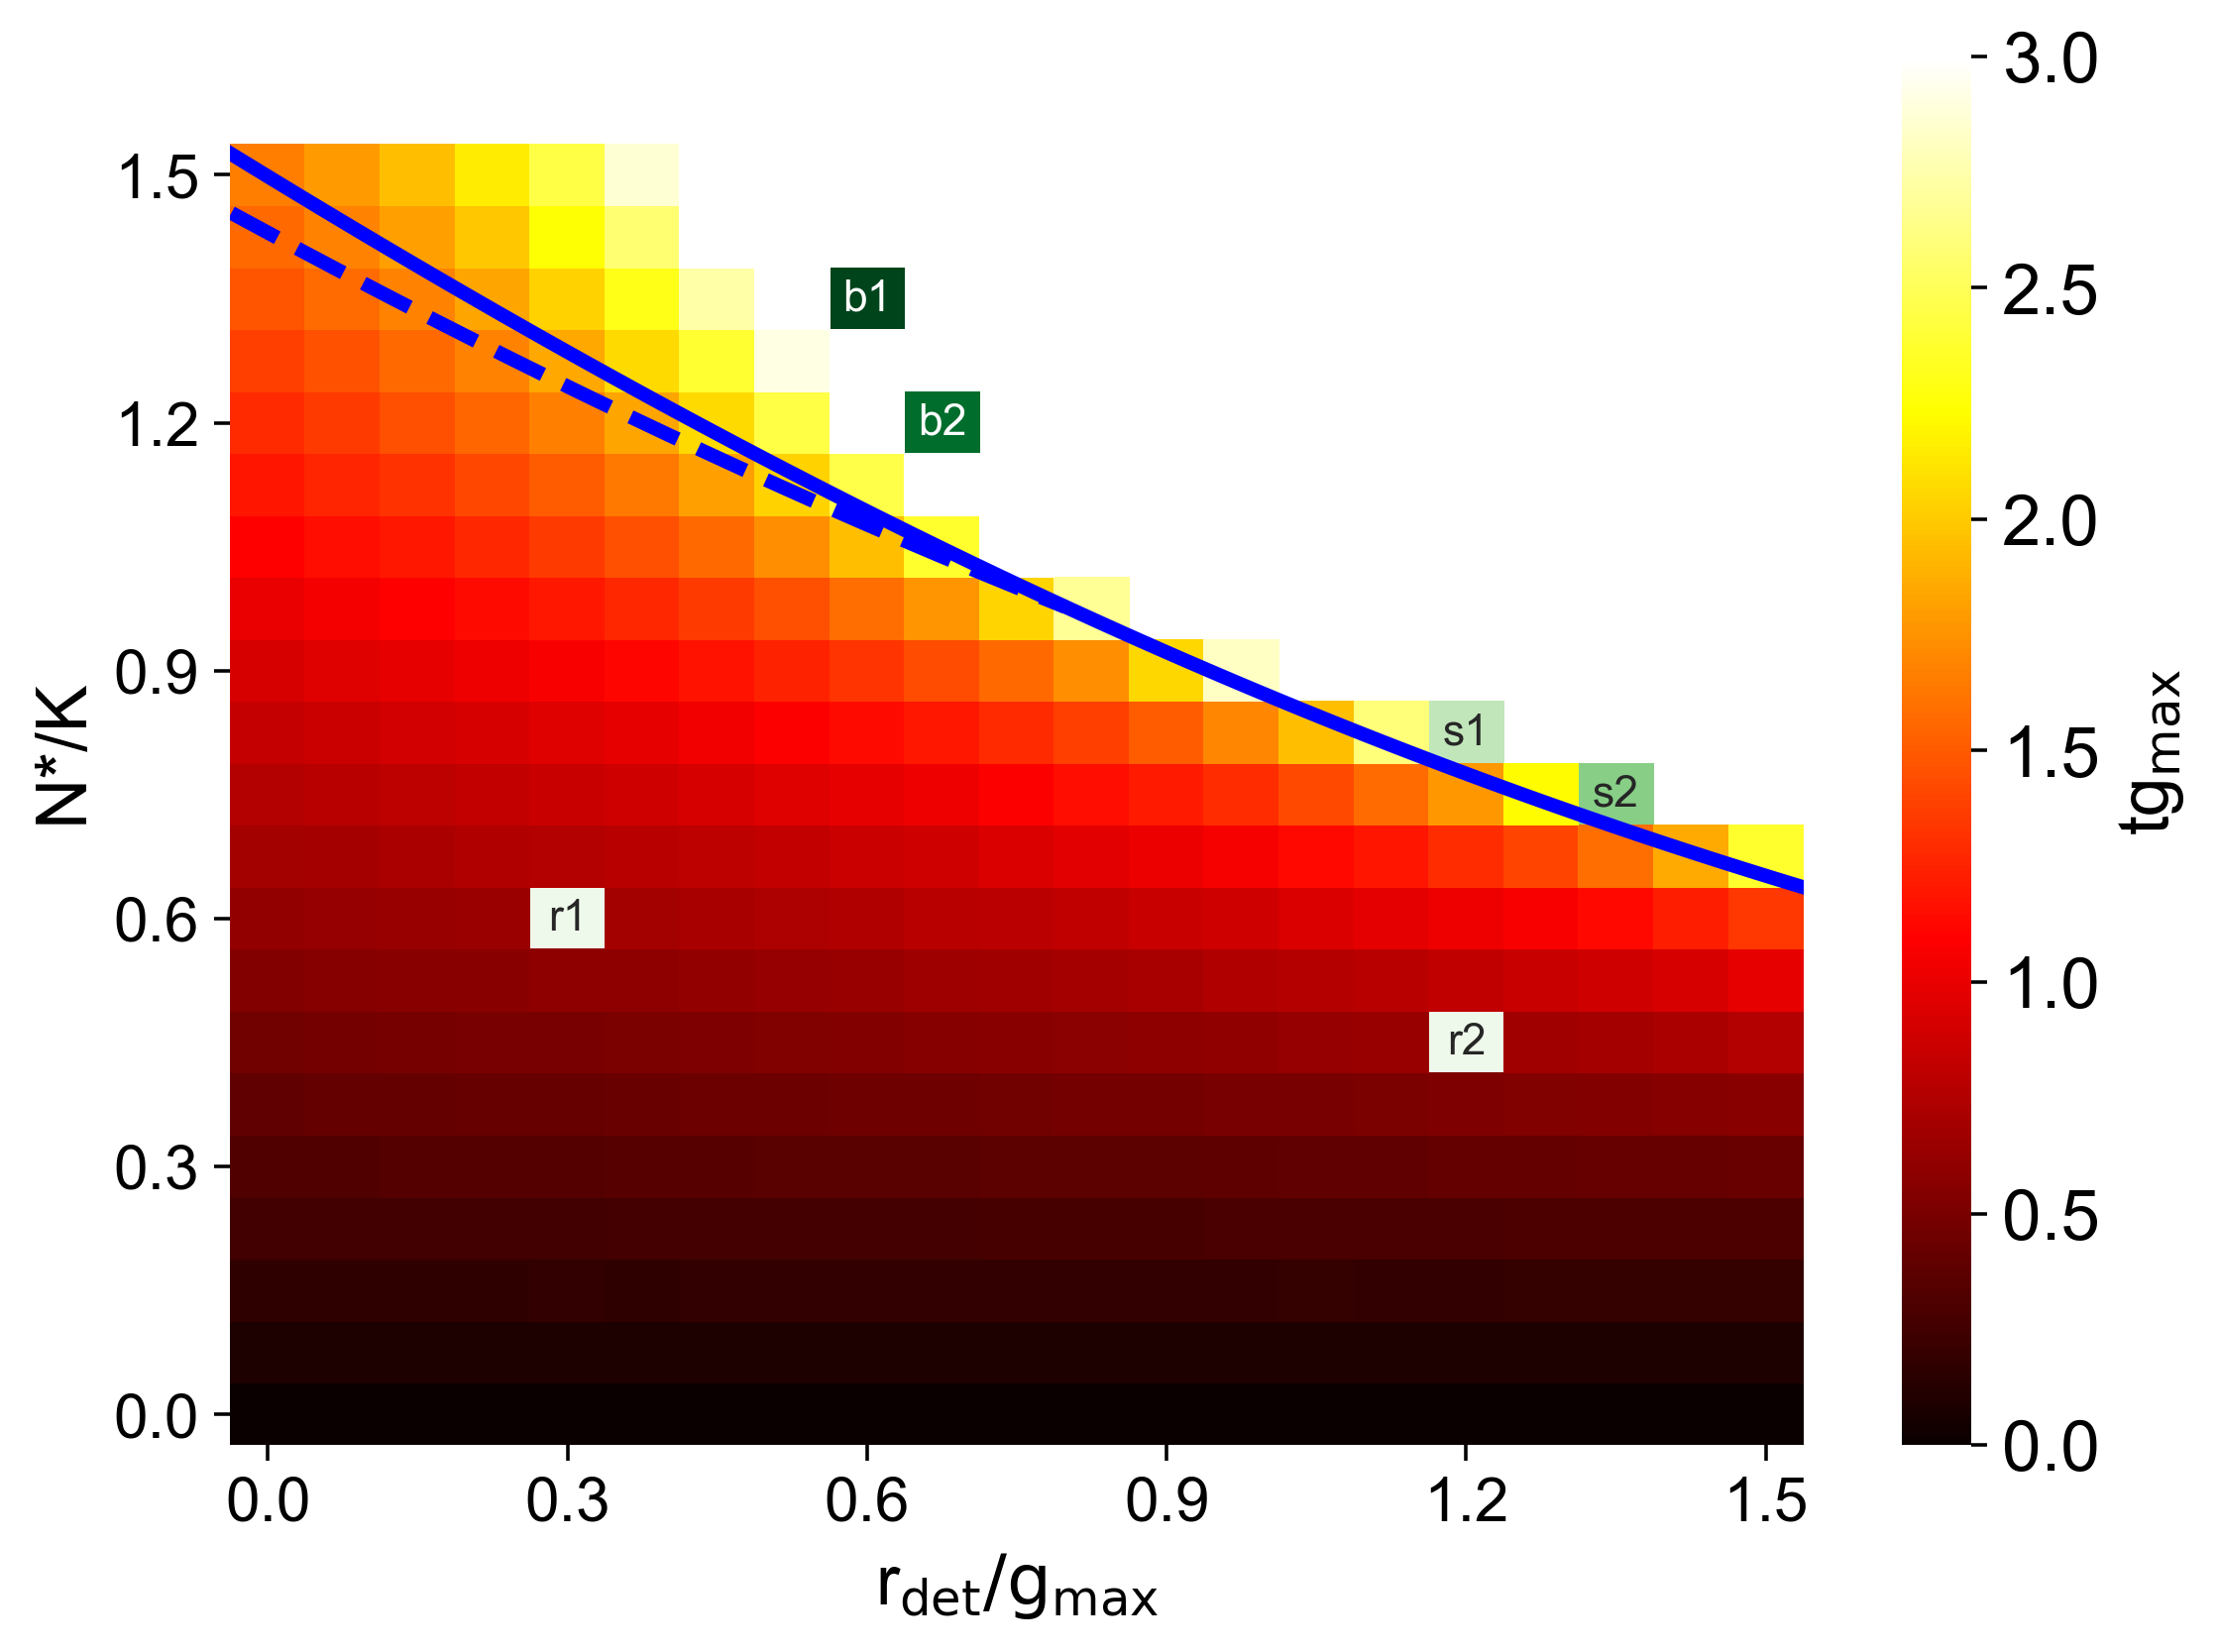

In [22]:
'''
Here we'll replot the t1 heatmap, but with the histogrammed squares highlighted
'''
fig, ax = plt.subplots(dpi=320)
fig.set_size_inches(8, 5.8)
titleSize = 16
labelSize = 16
numbersize = 14
legendsize = 10
IDsize=12


# #this mask will only plot values between 15 and 20
# masko = (pivot < 15) | (pivot >= 20)

# #phase_mask = (pivot['det_ratio']) > 0.5

ax = sns.heatmap(pivot, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True, cbar=True, vmax=3.)

pivot_min = np.nanmin(pivot.values)
pivot_max = np.nanmax(pivot.values)
#print(pivot_min)
masko_full = np.zeros_like(pivot)
#for n_thresh, r_det, label in zip(histogram_param_pairs, histogram_param_pair_labels):
for pp, label in zip(histogram_param_pairs, histogram_param_pair_labels):
    n_thresh, r_det = pp
    #pivot.keys() returns the values of r_det with floating point errors
    #following lines get the keys that are used in pivot
    r_det_key = (pivot.keys()[np.isclose(pivot.keys(), r_det)])[0]
    n_thresh_key = (pivot[r_det_key].keys()[np.isclose(pivot[r_det_key].keys(), n_thresh)])[0]
    
    r_det_key_index = np.where(np.isclose(pivot.keys(), r_det))[0][0]
    #print(pivot[pivot.keys()[r_det_key_index]])
    
    n_thresh_key_index = np.where(np.isclose(pivot[pivot.keys()[r_det_key_index]], n_thresh))
    
    #print(n_thresh_key_index)
    #print(r_det_key)
    #print(n_thresh_key)
    #print(np.where(np.isclose(pivot.keys(), r_det))[0][0])
    
    masko = np.isclose(pivot, pivot[r_det_key][n_thresh_key])
    masko_full += masko
    #print(mask)
    annotations = pivot.astype(str)
    annotations[masko] = label
    ax = sns.heatmap(pivot, mask=~masko, cmap='Greens', cbar=False, annot=annotations, fmt="s", vmin=pivot_min, vmax=pivot_max, xticklabels = 0, yticklabels=0)
    
    #print(pivot[0.07499999999999997].keys())
    #n_thresh_loc = pivot.columns.get_loc(n_thresh)
#     print(pivot.keys())
#     masko = (np.isclose(pivot["n_thresh"], n_thresh) & (np.isclose(pivot["det_ratio"], r_det)))
#     print(masko)
# ax_masked = sns.heatmap(pivot, mask=masko, cmap='Greens', cbar=False, annot=True)
# #ax_masked2 = sns.heatmap(pivot, mask=phase_mask, cmap='Blues', cbar=False, annot=True)

ax = sns.heatmap(pivot, annot=False, cmap='hot', xticklabels = 4, yticklabels=4, rasterized=True, cbar=False, mask=masko_full, vmax=3)

ax.invert_yaxis()
labels_x = [label.get_text() for label in ax.get_xticklabels()]
ax.set_xticklabels(map(lambda x: "{:.1f}".format(float(x)), labels_x))
labels_y = [label.get_text() for label in ax.get_yticklabels()]
ax.set_yticklabels(map(lambda y: "{:.1f}".format(float(y)), labels_y))


#plot the theoretical blue line #####################
theoryN_vals = np.vectorize(phase_diag_line)(det_ratio_vals)
# theoryN_vals[0] = 1.5
# theoryN_vals[-1] = 0.6
#print(theoryN_vals[0])
#print(theoryN_vals[-1])

#in order to get the line to be positioned correctly, need to multiply it by this scale factor.
#equal to the max value of the line divided by no. of squares in each axis
nsquares = len(param_data.index)**0.5 #no. of squares in each axis
scale_factor_x = nsquares/1.5
scale_factor_y = nsquares/1.5
sns.lineplot(x=det_ratio_vals*scale_factor_x, y=theoryN_vals*scale_factor_y, linewidth = 3.2, color="blue")
line = ax.lines[0] # get the line
line.set_ydata(line.get_ydata() - 0.5)



#plot the dashed line
det_ratio_vals_dashed = dashed_line_vals["r_det_ratio"]
theoryN_vals_dashed = dashed_line_vals["N_theory"]
#print(theoryN_vals_dashed[0])
#print(np.min(theoryN_vals_dashed))

scale_factor_x_dashed = nsquares/1.5
scale_factor_y_dashed = nsquares/1.5

sns.lineplot(x=det_ratio_vals_dashed*scale_factor_x_dashed, y=theoryN_vals_dashed*scale_factor_y_dashed, linewidth = 3.2, color="blue")
line = ax.lines[1] # get the line
line.set_ydata(line.get_ydata() - 0.5)
line.set_linestyle("--")
###########################################

ax.axis('tight')

ax.set_xlabel('r$_{\\rm det}/\\rm{g}_{\max}$', fontsize=labelSize)
ax.set_ylabel('N*/K', fontsize=labelSize)
ax.xaxis.set_tick_params(labelsize=numbersize)
ax.yaxis.set_tick_params(labelsize=numbersize)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelSize)
cbar.set_label("tg$_{\max}$", fontsize=labelSize)
cbar.ax.locator_params(nbins=6)

plt.xticks(rotation=0)
plt.savefig('timeTo1Microhab_powerLaw_bigK_plots/highlighted_t1_phase_diagram.pdf', bbox_inches='tight')
plt.show()

In [23]:
print(param_data["coeff_variation"][~np.isnan(param_data["coeff_variation"])])

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
423    0.014764
424    0.009513
425    0.015738
426    0.029316
427    0.091245
Name: coeff_variation, Length: 337, dtype: float64


In [24]:
print(param_data)

     n_thresh  det_ratio  time_to_n  time_elapsed  time_to_n_raw  \
0         0.0      0.000        0.0  9.000000e+09            0.0   
1         0.0      0.075        0.0  9.000000e+09            0.0   
2         0.0      0.150        0.0  9.000000e+09            0.0   
3         0.0      0.225        0.0  9.000000e+09            0.0   
4         0.0      0.300        0.0  9.000000e+09            0.0   
..        ...        ...        ...           ...            ...   
436       1.5      1.200        0.0  2.560460e+02            0.0   
437       1.5      1.275        0.0  2.560527e+02            0.0   
438       1.5      1.350        0.0  2.560466e+02            0.0   
439       1.5      1.425        0.0  2.560524e+02            0.0   
440       1.5      1.500        0.0  2.560489e+02            0.0   

     time_to_n_stDev  coeff_variation  tN_adjusted  tN_stDev_adjusted  \
0                0.0              0.0          0.0                0.0   
1                0.0              0.0

(array([42., 32., 30., 29., 27., 24., 19., 18., 15., 11., 12., 10.,  7.,
         8.,  3.,  3.,  6.,  2.,  2.,  4.]),
 array([0.085075  , 0.22649057, 0.36790615, 0.50932172, 0.65073729,
        0.79215286, 0.93356844, 1.07498401, 1.21639958, 1.35781516,
        1.49923073, 1.6406463 , 1.78206188, 1.92347745, 2.06489302,
        2.20630859, 2.34772417, 2.48913974, 2.63055531, 2.77197089,
        2.91338646]),
 <a list of 20 Patch objects>)

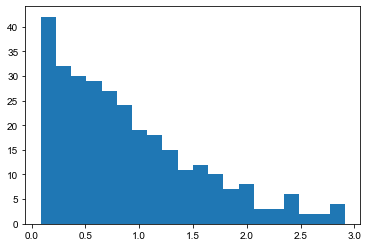

In [25]:
plt.hist(param_data["tN_adjusted"][(param_data["tN_adjusted"]>0) & (param_data["tN_adjusted"]<3)].values, bins=20)
#plt.show()